# Basic regression with ARIMA errors.

This notebook contains an implemenation of regression with ARIMA errors.

In this implementation months of the year and weeks of the year are represented by seasonal indexes (dummy variables either 0 or 1).

## Imports

In [1]:
import pandas as pd
import numpy as np

from forecast_tools.baseline import SNaive, Naive1
from forecast_tools.metrics import mean_absolute_error
from forecast_tools.datasets import load_emergency_dept

from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore')

## Helper functions

In [2]:
def preds_as_series(data, preds):
    '''
    Helper function for plotting predictions.
    Converts a numpy array of predictions to a 
    pandas.DataFrame with datetimeindex
    
    Parameters
    -----
    data - arraylike - the training data
    preds - numpy.array, vector of predictions 
    
    Returns:
    -------
    pandas.DataFrame
    '''
    start = pd.date_range(start=data.index.max(), periods=2, 
                          freq=data.index.freq).max()
    idx = pd.date_range(start=start, periods=len(preds), freq=data.index.freq)
    return pd.DataFrame(preds, index=idx)

In [3]:
def plot_prediction_intervals(train, preds, intervals, 
                              test=None, show_train_size=None, figsize=(12,4)):
    '''
    Helper function to plot training data, point preds
    and 2 sets of prediction intevals
    
    assume 2 sets of PIs are provided!
    '''
    
    if show_train_size is None:
        show_train_size = len(train)
        
    train = train[-show_train_size:]
    ax = train.plot(figsize=figsize)
    

    mean = preds_as_series(train, preds)
    intervals_80 = preds_as_series(train, intervals[0])
    intervals_90 = preds_as_series(train, intervals[1])

    mean.plot(ax=ax, label='point forecast')

    ax.fill_between(intervals_80.index, mean[0], intervals_80[1], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,mean[0], intervals_80[0], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,intervals_80[1], intervals_90[1], 
                    alpha=0.2,
                    label='90% PI', color='purple');

    ax.fill_between(intervals_80.index,intervals_80[0], intervals_90[0], 
                    alpha=0.2,
                    label='90% PI', color='purple');
    
    if test is None:
        ax.legend(['train', 'point forecast', '80%PI', '_ignore','_ignore', 
                   '90%PI'], loc=2)
    else:
        test.plot(ax=ax, color='black', marker='o', ls='')
        ax.legend(['train', 'point forecast', 'Test', '80%PI', 
                   '_ignore','_ignore', '90%PI'], loc=2)

# Function to get seasonal indexes

In [4]:
def get_seasonal_indexes(idx, include_month=True, include_dow=True):
    '''
    Seasonal indexes for use with regression.
    
    Params:
    ------
    idx: pd.DataTimeIndex
        Dates inclued in the dataframe
        
    include_month: bool, optional (default=True)
        Include 11 dummy variables for month of year
        
    include_dow: bool. optional (default=False)
        Include 6 dummy variables for month of year
        
    Returns:
    --------
    pd.DataFrame
    
    '''
    seasonal_idx = pd.DataFrame()
    
    if include_month:
        # uses the pd.get_dummies function 
        seasonal_idx = pd.concat([seasonal_idx, 
                                  pd.get_dummies(idx.month,  
                                                 prefix='m', 
                                                 drop_first=True)], axis=1)
        
    if include_dow:
        seasonal_idx = pd.concat([seasonal_idx, 
                                  pd.get_dummies(idx.weekday, prefix='dow', 
                                                 drop_first=True)], axis=1)
        
    # set the index
    seasonal_idx.index = idx
        
    return seasonal_idx

## Example with `forecast_tools` ED dataset

In [5]:
TARGET = 0.80
HOLDOUT = 28
PERIOD = 7

# built in dataset
attends = load_emergency_dept()

# train-test split
train = attends[:-HOLDOUT]
test = attends[-HOLDOUT:]

X = get_seasonal_indexes(train.index)
# quick look at 
X.tail(7)

,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
date,,,,,,,,,,,,,,,,,
2017-11-27,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2017-11-28,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2017-11-29,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2017-11-30,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2017-12-01,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2017-12-02,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2017-12-03,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


## Use auto_arima with one small change

In pass in the regressors in X (known as exogenous variables).

In [6]:
# this will take a few minutes to run and fit all models.
model = auto_arima(train, exogenous=X, m=PERIOD, d=1, supress_warnings=True, 
                   maxiter=100)

In [7]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  316
Model:             SARIMAX(5, 1, 0)x(2, 0, 0, 7)   Log Likelihood               -1334.532
Date:                           Fri, 04 Feb 2022   AIC                           2719.064
Time:                                   15:08:09   BIC                           2812.878
Sample:                               01-22-2017   HQIC                          2756.546
                                    - 12-03-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
m_2            2.0864     20.881      0.100      0.920     -38.840      43.012
m_3            2.2751     23.654      0.096      0.923     -44.086      48.636
m_4            2.5560     25.483      0.100      0.920     -47.390      52.502
m_5           -7.0905     29.185     -0.243      0.808     -64.291      50.110
m_6           -0.4070     34.083     -0.012      0.990     -67.208      66.394
m_7            0.6652     38.435      0.017      0.986     -74.666      75.996
m_8            3.1819     45.017      0.071      0.944     -85.050      91.414
m_9            6.3649     50.052      0.127      0.899     -91.735     104.464
m_10          -3.1630     50.851     -0.062      0.950    -102.828      96.502
m_11           0.5002     52.233      0.010      0.992    -101.875     102.875
m_12          -3.9117     53.467     -0.073      0.942    -108.705     100.881
dow_1         -5.3309      2.465     -2.162      0.031     -10.163      -0.499
dow_2         29.9016      2.711     11.029      0.000      24.588      35.215
dow_3         43.0327      2.677     16.075      0.000      37.786      48.279
dow_4         27.3758      2.768      9.889      0.000      21.950      32.802
dow_5          8.0352      2.892      2.779      0.005       2.367      13.703
dow_6         -0.4548      2.814     -0.162      0.872      -5.970       5.060
ar.L1         -0.8110      0.061    -13.328      0.000      -0.930      -0.692
ar.L2         -0.6475      0.078     -8.321      0.000      -0.800      -0.495
ar.L3         -0.4670      0.082     -5.723      0.000      -0.627      -0.307
ar.L4         -0.3390      0.083     -4.096      0.000      -0.501      -0.177
ar.L5         -0.1832      0.067     -2.730      0.006      -0.315      -0.052
ar.S.L7       -0.0777      0.058     -1.336      0.181      -0.192       0.036
ar.S.L14      -0.1598      0.067     -2.397      0.017      -0.290      -0.029
sigma2       280.4508     23.168     12.105      0.000     235.042     325.860
===================================================================================
Ljung-Box (Q):                       58.27   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.03   Prob(JB):                         0.75
Heteroskedasticity (H):               0.99   Skew:                            -0.00
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Making a forecast

We will do this similar to Prophet and create a "future" dataframe that holds all of our regressors for the period we want to predict.

In [8]:
def make_future_dataframe(h, y_train, include_mth=True, include_dow=True):
    '''
    Make a dataframe h steps into the future of y_train
    
    Params:
    ------
    h: int
        Forecast horizon
        
    y_train: pd.DataFrame
        Dataframe containing training data.  Must have a DataTimeIndex
    
    '''
    idx = pd.date_range(start=y_train.iloc[-1].name, periods=y_train.shape[0]+h, 
                        freq='D')
    seasonal_idxs = get_seasonal_indexes(idx, include_month=True, 
                                         include_dow=True)
    return seasonal_idxs.iloc[-h:]


In [9]:
# future_dataframe just holds our X regression i.e. seasonal indexes in the future
future_dataframe = make_future_dataframe(HOLDOUT, train)
future_dataframe.head()

,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
2018-10-15,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2018-10-16,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2018-10-17,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2018-10-18,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2018-10-19,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


The forecast function is just for convenience.  It calls the model.predict method

In [10]:
def forecast(model, future_dataframe, return_predict_int=True, alpha=0.05):
    '''
    Forecast with regression with ARIMA errors
    
    Params:
    ------
    h: int
        Forecast horizon
        
    future_dataframe: pd.DataFrame
        Future dataframe containing datetimeindex + seasonal indexes
    
    return_predict_int: bool, optional (default=True)
        Prediction interval with predictions
        
    alpha: float, optional (Deault=0.05)
        1 - coverage for prediction interval
        
    Returns:
    --------
    preds, intervals
    '''
    
    h = future_dataframe.shape[0]
    return model.predict(n_periods=h, exogenous=future_dataframe, 
                         return_conf_int=return_predict_int, 
                         alpha=alpha)

In [11]:
# Forecast and get 95 and 80% prediction intervals 
preds, intervals_95 = forecast(model, future_dataframe, alpha=0.05)
preds, intervals_80 = forecast(model, future_dataframe, alpha=0.2)
intervals = np.array([intervals_80, intervals_95])

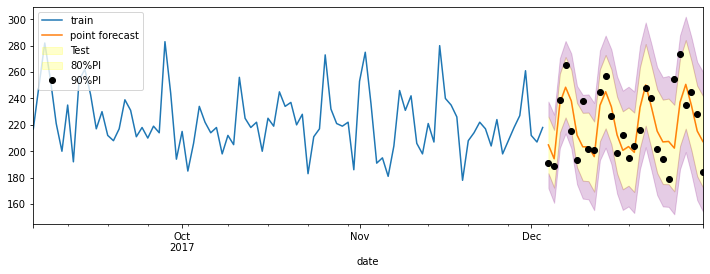

In [12]:
plot_prediction_intervals(train, preds, intervals, test=test, 
                          show_train_size=90)